In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import fista
import timeit
from itertools import combinations
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# 1. Preliminaries

## Load basis functions

In [2]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels.  (~1.2 times overcomplete)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

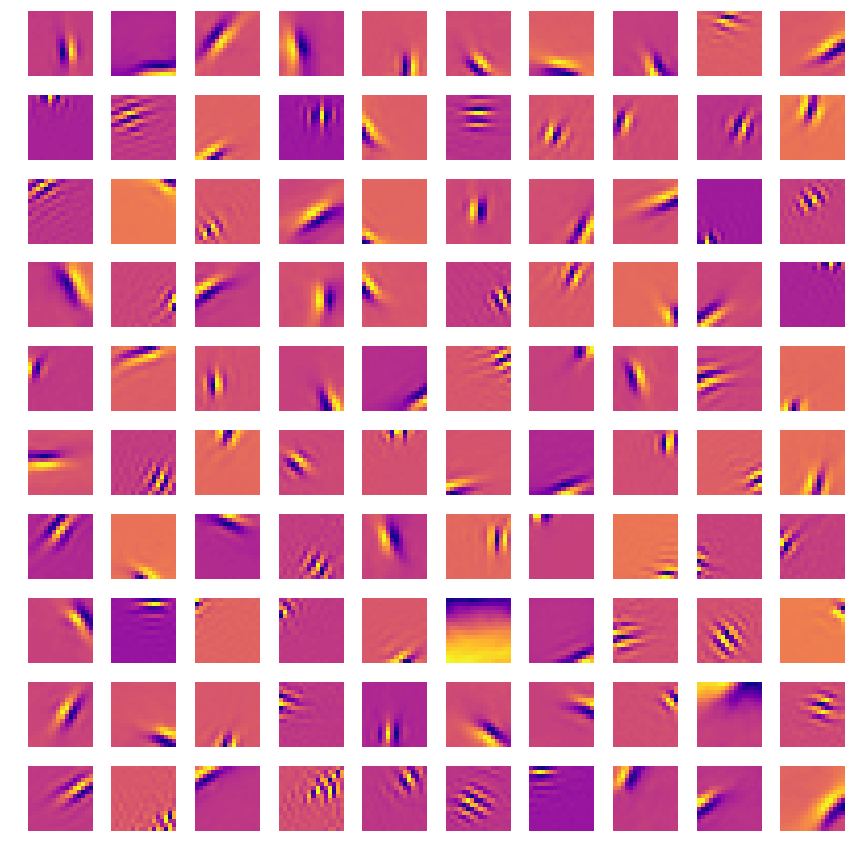

In [3]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [4]:
IMAGES = scipy.io.loadmat('IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

## Randomly select image patches

In [5]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I

In [6]:
I = sample_images(1000, IMAGES)

## Find coefficients of sparse representation

In [7]:
ahat = fista.fista(I, bases, lambdav = 0.1, max_iterations=50)

In [8]:
ahat_list2 = np.zeros([100, ahat.shape[0], ahat.shape[1]])

## Compute correlations between neuron pairs; plot as histogram

In [9]:
corr_list = []
neuron_pairs = combinations(range(300),2)

for i,j in neuron_pairs:
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    corr_list.append(corr)
    if abs(corr) > 0.3 and i != j:
        print(i,j)

4 43
14 204
28 154
34 239
40 273
57 269
68 227
71 130
84 275
118 141
134 298
135 252
138 160
140 229
144 226
145 239
184 226


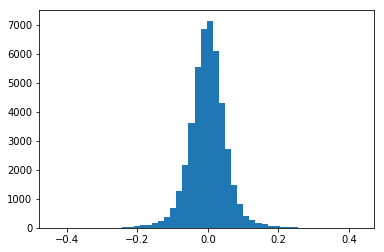

In [10]:
corr_hist = plt.hist(corr_list,50)
plt.show()

0.294003692839


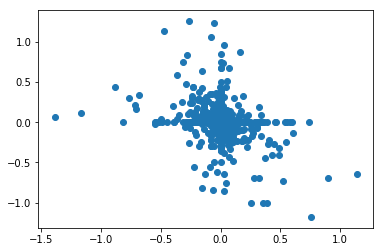

In [11]:
plt.scatter(ahat[71,:], ahat[130,:])
print(np.corrcoef(ahat[22,:], ahat[149,:])[0, 1])
plt.show()

In [12]:
def find_strong_image(neuron1, neuron2):
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > 0.1 and abs(ahat[neuron2,:][i]) > 0.1:
            return(i)
        
def find_strong_images(neuron1, neuron2, cutoff = 0.5):
    image_nums = []
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > cutoff and abs(ahat[neuron2,:][i]) > cutoff:
            image_nums.append(i)
    if len(image_nums) == 0:
        image_nums = find_strong_images(neuron1,neuron2, cutoff = cutoff - 0.05)
    return(image_nums)

In [14]:
print(find_strong_images(22,149,0.3))

[316, 446, 806]


In [15]:
def add_noise(image, sigma = 1e-1):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

def plot_neurons(i,j, responses):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()

In [16]:
def get_noisy_responses(image):
    for i in range(100):
        ahat_list2[i] = fista.fista(add_noise(image, 1e-1), bases, lambdav = 0.1, max_iterations = 50)
    """responses = np.zeros((bases.shape[1], num_trials))
    image_num = find_strong_image(neuron1, neuron2)  
    selected_image = np.reshape(I[:,image_num], (256,1))

    for i in range(num_trials):
        ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
        responses[:, i] = ahat2[:, 0]
        
    corr = np.corrcoef(responses[neuron1,:], responses[neuron2,:])[0, 1]
    
    return(corr)"""
    
def get_noise_correlations(neuron1, neuron2):
    corr = 0
    image_nums = find_strong_images(neuron1, neuron2)
    for image_num in image_nums:
        corr += np.corrcoef(ahat_list2[:,neuron1,image_num], ahat_list2[:,neuron2,image_num])[0, 1]
    return(corr/len(image_nums))
    

In [17]:
get_noisy_responses(I)

In [26]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    corr = get_noise_correlations(neuron1, neuron2)
    noise_corr_list.append(corr)

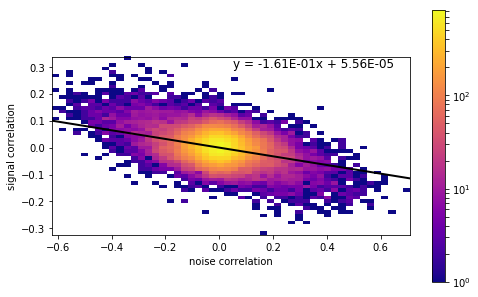

"plt.scatter(noise_corr_list, corr_list)\nplt.axis('equal')\nplt.show()"

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
counts,ybins,xbins,image = ax.hist2d(noise_corr_list, corr_list,(50,50), cmap = 'plasma', norm = LogNorm())
import seaborn as sns

m,b = np.polyfit(noise_corr_list, corr_list, 1)
ax.plot([-1.0, 1.0], [-m + b, m + b], color='k', linestyle='-', linewidth=2)
s = 'y = {0:1.2E}x + {1:1.2E}'.format(m,b)
ax.text(0.05, 0.30, s, fontsize=12)
plt.xlabel('noise correlation')
plt.ylabel('signal correlation')
ax.set_aspect('equal')
plt.colorbar(image)

plt.savefig('foo.png', bbox_inches='tight')
plt.show()


#sns.kdeplot(noise_corr_list, corr_list, cmap="Reds", shade=True)
#plt.title('Overplotting? Try 2D density graph', loc='left')
plt.show()

"""plt.scatter(noise_corr_list, corr_list)
plt.axis('equal')
plt.show()"""

In [ ]:
print(ahat_list[:,0,3])
plt.hist(ahat_list[:,0,8], 20)
plt.show()

In [ ]:
plot_neurons(58,148, responses)

# Signal correlation vs noise correlation

In [ ]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    noise_corr_list.append(get_noise_correlation(neuron1, neuron2))
    

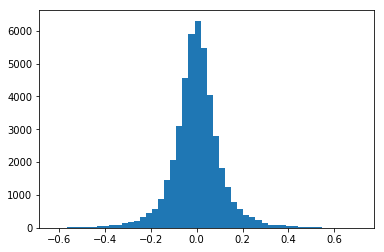

In [28]:
corr_hist = plt.hist(noise_corr_list,50)
plt.show()

# HMC sampling

Energy function

In [15]:
def U(x):
    return (x - 2.0)**2
    #return -np.log( np.exp(-(x - 3.0)**2))

def dU(x):
    return (U(x + eps) - U(x))/eps
    

def K(v):
    return 0.5*v**2

def H(s):
    return U(s[0]) + K(s[1])

Leap-Frog algorithm

In [16]:
def Leap(x,v,n):
    v = v - 0.5*eps*dU(x)
    for i in range(n):
        x = x + eps*v
        if i != (n - 1):
            v = v - eps*dU(x)
    v = v - 0.5*eps*dU(x)
    return x,v
    

Metropolis accept/reject

In [17]:
def accept(s_i, s_f):
    prob = min(1, np.exp(-H(s_f))/np.exp(-H(s_i)))
    if np.random.uniform() < prob:
        return s_f
    else:
        #print("not acccepted")
        #print(s_i, s_f)
        return s_i  #The current state is counted again according to the R. Neal paper (5.3.2.1)

In [18]:
sigma = 0.1
num_samples = 1000
n = 25
eps = 1e-2
v = np.random.normal(0.0, sigma)
x = np.random.normal(0.0, sigma)
s = [x,v]
X = []

In [19]:
for i in range(num_samples):
    v = np.random.normal(0.0, sigma)
    x,v = Leap(x,v,n)
    v = -v
    s = accept(s, [x,v])
    X.append(s[0])
    s = [x,v]


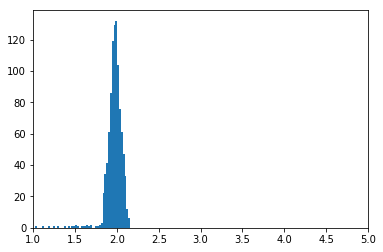

In [20]:
plt.hist(X, bins = 100)
plt.xlim((1.0,5.0))
plt.show()

## Extras

In [ ]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10,10), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [67,81]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

In [ ]:
plt.imshow(np.reshape(I[:,835], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

In [ ]:
reco = np.dot(bases, responses[:, 1])
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
print(reco.size)
plt.show()

In [ ]:
print(ahat.shape)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i,835]) > 0.3:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

In [ ]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [ ]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

In [ ]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()